In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.special import expit  # sigmoid
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# **Main flow explaination**
<p align="center">
  <img src="CF_flow.png" alt="title" width="500">
</p>

### **Step 1: Retrieving the Dataset**  
- The dataset **MovieLens 1M** is collected directly from an online source.  

### **Step 2: Exploring and Preprocessing the Dataset**  
- The dataset undergoes **preprocessing** and **exploratory analysis** to ensure it is suitable for modeling.  
- After preprocessing, the data is **ready for model training**.  
- Additionally, several **insights** are extracted to facilitate **manual evaluation** of the final model's performance.  

### **Step 3: Building the Model Architecture**  
- The **Collaborative Filtering (CF)** model is developed from scratch. Notably, **Stochastic Gradient Descent (SGD)** and its related computations are **manually implemented** (without using pre-built optimization libraries).  
- The construction process involves the following key steps:  
  - **Randomly initialize latent factor vectors** for users.  
  - **Randomly initialize latent factor vectors** for items (movies).  
  - Define and use **Squared Error (SE) Loss** for optimization.  
  - Apply **Stochastic Gradient Descent (SGD)** to optimize the model parameters.  

### **Step 4: Ranking and Predicting Recommendations**  
- This phase is divided into two main parts:  
  1. **Top-N Recommendation**:  
      - Use the **trained model** to recommend the top N movies suitable for a given user \( J \).  
  2. **(Optional) Genre-Based Tie-Breaking**:  
      - Identify the **top 5 genres** based on the two highest-rated movies by user \( J \). For example, if user \( J \) rates two movies with 4 stars, and genres like *Drama* and *Children's* appear 12 and 11 times respectively, their **relative weights** will be calculated as:  
        \[
        \text{Weight of Drama} = \frac{12}{23} \approx 0.52
        \]  
      - In cases where multiple movies share the same predicted rating (rounded to one decimal place, e.g., 0.2f), these **genre weights** are used as a **tie-breaking criterion** to prioritize recommendations.  

### **Step 5: Testing and Evaluating the Model**  
- **Training cost (loss)** is analyzed to assess the model's learning quality and convergence.  
- Additionally, the **insights gathered in Step 2** are leveraged for **qualitative, manual evaluation** of the recommendation results.  


# **Step 1: Retrieving the Dataset**  

In [2]:
# ====================== Explore Data ======================
# Load datasets
r_cols = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', names=r_cols, engine='python')
ratings.drop('timestamp', axis=1, inplace=True)

u_cols = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_csv('ml-1m/users.dat', sep='::', names=u_cols, engine='python')

m_cols = ['item_id', 'title', 'genres']
movies = pd.read_csv('ml-1m/movies.dat', sep='::', names=m_cols, engine='python', encoding='latin-1')

## Ratings Dataset

In [3]:
ratings.head(3)

,user_id,item_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3


- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

## Movies Dataset

In [4]:
movies.head(3)

,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist

## Users dataset

In [5]:
users.head(3)

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117


- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

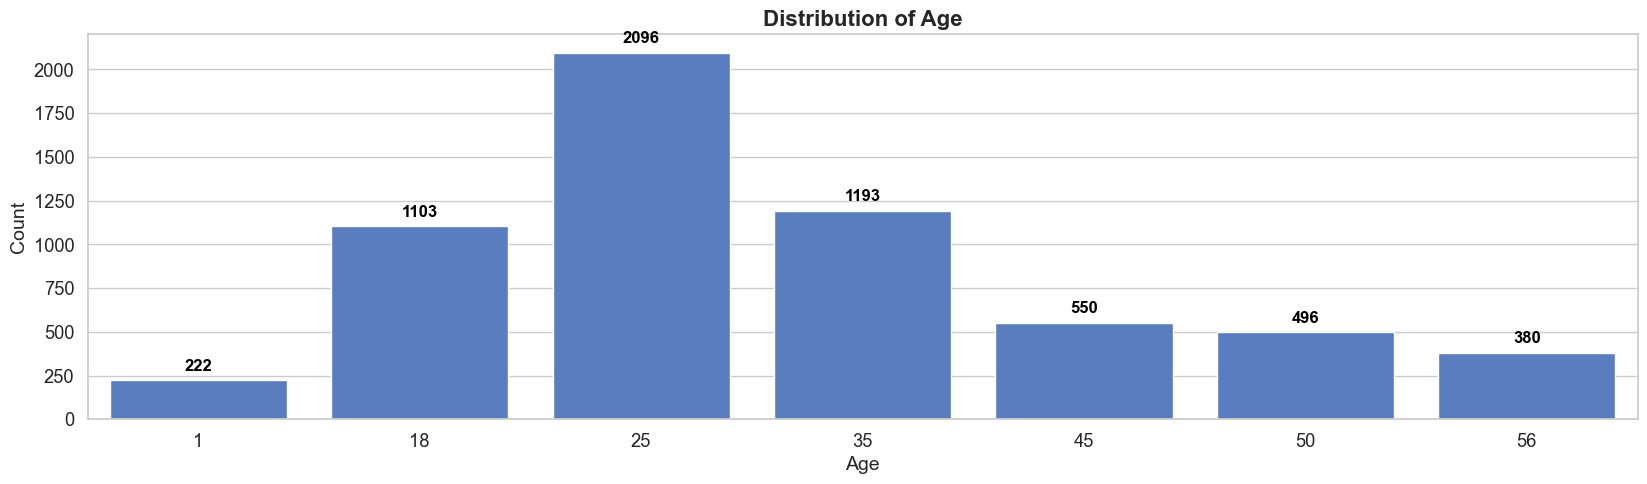

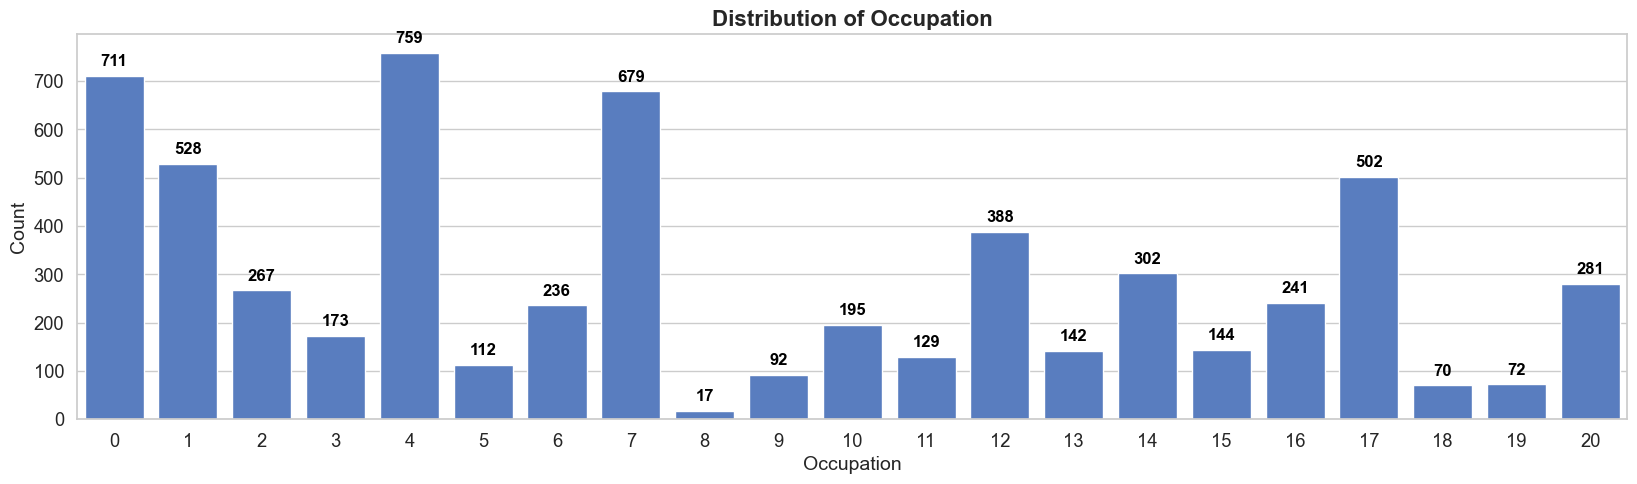

In [6]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

def annotate_bars(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}',                
                    xy=(p.get_x() + p.get_width() / 2, height),  
                    xytext=(0, 5),                  
                    textcoords='offset points',   
                    ha='center', va='bottom',      
                    fontsize=12, color='black', weight='bold')  

# --- Bar Chart for Age ----
plt.figure(figsize=(20, 5))
sorted_ages = sorted(users['age'].unique())  # Sắp xếp tăng dần
ax1 = sns.countplot(x='age', data=users, order=sorted_ages)
plt.title('Distribution of Age', fontsize=16, weight='bold')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
annotate_bars(ax1)  
plt.show()

# --- Bar Chart for Occupation ---
plt.figure(figsize=(20, 5))
sorted_occupations = sorted(users['occupation'].unique())  
ax2 = sns.countplot(x='occupation', data=users, order=sorted_occupations)
plt.title('Distribution of Occupation', fontsize=16, weight='bold')
plt.xlabel('Occupation', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
annotate_bars(ax2)  
plt.show()

# **Step 2: Exploring and Preprocessing the Dataset**  

In [7]:
# ====================== Preprocess Data ======================
# Create mappings for items and users
item_id_to_index = {item_id: idx for idx, item_id in enumerate(movies['item_id'].unique())}
index_to_item_id = {idx: item_id for item_id, idx in item_id_to_index.items()}
user_id_to_index = {user_id: idx for idx, user_id in enumerate(users['user_id'].unique())}
index_to_user_id = {idx: user_id for user_id, idx in user_id_to_index.items()}

num_users = len(user_id_to_index)
num_items = len(item_id_to_index)

# **Step 3: Building the Model Architecture**  

In [1]:
# ================== Collaborative Filtering (CF) Class =====================

class CF:
    def __init__(self, num_users, num_items, num_factors=50, lr=0.01, reg=0.01, epochs=20):
        """
        Initializes the Collaborative Filtering model.

        Args:
            num_users (int): Number of users in the dataset.
            num_items (int): Number of items in the dataset.
            num_features (int): Number of features for content-based filtering.
            num_factors (int, optional): Number of latent factors for collaborative filtering. Default is 20.
            lr (float, optional): Learning rate for stochastic gradient descent. Default is 0.01.
            reg (float, optional): Regularization parameter. Default is 0.01.
            epochs (int, optional): Number of epochs for training. Default is 20.
        """

        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = num_factors
        self.lr = lr
        self.reg = reg
        self.epochs = epochs
        self.scaler = StandardScaler()
        # CF latent factors
        self.user_factors = np.random.normal(scale=1./num_factors, size=(num_users, num_factors))
        self.item_factors = np.random.normal(scale=1./num_factors, size=(num_items, num_factors))
        

    def train(self, train_data, item_id_to_index, user_id_to_index):
        """
        Trains the Collaborative Filtering model using SGD.

        Args:
            train_data (DataFrame): Training data containing user-item interactions.
            item_id_to_index (dict): Mapping from item IDs to matrix indices.
            user_id_to_index (dict): Mapping from user IDs to matrix indices.

        Returns:
            Vectors after stochastic gradient descent
        """
        train_data[['rating']] = self.scaler.fit_transform(train_data[['rating']])
        print("One piece of training data:\n", train_data['rating'][:5], "\n")
        losses = []

        for epoch in range(self.epochs):
            total_loss = 0
            train_data = train_data.sample(frac=1).reset_index(drop=True)  # Shuffle

            for row in tqdm(train_data.itertuples(), total=len(train_data), desc=f'Epoch {epoch+1}'):
                user_id, item_id, rating = row.user_id, row.item_id, row.rating
                user = user_id_to_index.get(user_id, None)
                item = item_id_to_index.get(item_id, None)
                if user is None or item is None:
                    continue # Skip if user or item is unknown

                # Collaborative Filtering Prediction
                pred_cf = np.dot(self.user_factors[user], self.item_factors[item])

                # Final prediction
                pred = pred_cf
                error = rating - pred
                total_loss += error**2 + self.reg * (np.linalg.norm(self.user_factors[user])**2 + np.linalg.norm(self.item_factors[item])**2) # L2 Regularization

                # --- SGD Update ---
                # CF part
                user_grad = -2 * error * self.item_factors[item] + 2 * self.reg * self.user_factors[user]
                item_grad = -2 * error * self.user_factors[user] + 2 * self.reg * self.item_factors[item]
                self.user_factors[user] -= self.lr * user_grad
                self.item_factors[item] -= self.lr * item_grad

            print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
            losses.append(total_loss)
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss per Epoch')
        plt.grid(True)
        plt.show()

    def predict(self, user_id, item_id, item_id_to_index, user_id_to_index):
        """
        Returns the predicted rating for a given user and item.

        Args:
            user_id (int): ID of the user.
            item_id (int): ID of the item.
            item_id_to_index (dict): Mapping from item IDs to matrix indices.
            user_id_to_index (dict): Mapping from user IDs to matrix indices.

        Returns:
            float: Predicted rating.
        """
    
        user = user_id_to_index.get(user_id, None)
        item = item_id_to_index.get(item_id, None)
        if user is None or item is None:
            return 0  # Default prediction if unknown user/item

        pred_cf = np.dot(self.user_factors[user], self.item_factors[item])
        pred_cf = self.scaler.inverse_transform([[pred_cf]])[0][0]
        pred = min(5, max(1, pred_cf))  # Clip prediction to [1, 5]
        return pred

    def count_genres_all_ratings(self, ratings_df, movies_df, user_id, top):
        """
        Returns the count of each genre for each rating (1 to 5) of a user.

        Args:
            ratings_df (DataFrame): Ratings data.
            movies_df (DataFrame): Movies data.
            user_id (int): ID of the user to analyze.
            top (int): Maximum number of genres to return.

        Returns:
            DataFrame: Table with columns 'rating', 'genre', 'count'.
        """
        df = pd.merge(ratings_df, movies_df, on='item_id')

        all_genres = set()
        for genre_list in movies['genres'].str.split('|'):
            all_genres.update(genre_list)
        all_genres = list(all_genres)

        user_df = df[df['user_id'] == user_id]

        exploded = user_df.assign(genre=user_df['genres'].str.split('|')).explode('genre')

        genre_counts = exploded.groupby(['rating', 'genre']).size().reset_index(name='count')

        genre_counts = genre_counts.sort_values(by=['rating', 'count'], ascending=[True, False])
        if top < len(all_genres):
            genre_counts = genre_counts.groupby('rating').head(top)

        return genre_counts

    def calculate_genre_weights(self, filtered_result):
        """
        Calculate the weight of each genre for each rating.

        Args:
            filtered_result (DataFrame): DataFrame containing the count of each genre for each rating.

        Returns:
            DataFrame: DataFrame with columns 'rating', 'genre', 'count', 'weight'.
        """
        # Calculate the total count for each rating
        total_counts = filtered_result.groupby('rating')['count'].sum().reset_index(name='total_count')

        # Merge the total counts with the filtered result
        merged_result = pd.merge(filtered_result, total_counts, on='rating')

        # Calculate the weight for each genre
        merged_result['weight'] = merged_result['count'] / merged_result['total_count']

        return merged_result[['rating', 'genre', 'count', 'weight']]


    def recommend(self, user_id, item_id_to_index, user_id_to_index, ratings_df, movies_df, top_n):
        """
        Returns the count of each genre for each rating (1 to 5) of a user.

        Args:
            user_id (int): ID of the user to analyze.
            item_id_to_index (dict): Mapping from item IDs to matrix indices.
            user_id_to_index (dict): Mapping from user IDs to matrix indices.
            ratings_df (DataFrame): Ratings data.
            movies_df (DataFrame): Movies data.
            top (int): Maximum number of genres to return.

        Returns:
            List of tuples: List of (item_id, score, weight) sorted tuples for the top N recommended items.
        """
        
        scores = []
        for item_id in item_id_to_index.keys():
            score = self.predict(user_id, item_id, item_id_to_index, user_id_to_index)
            scores.append((item_id, round(score, 2)))
        scores.sort(key=lambda x: x[1], reverse=True)
        print("scores: ", scores[:10])

        count_genres = self.count_genres_all_ratings(ratings_df, movies_df, user_id, top_n)
        # print("countgenre:", count_genres)
        top_ratings = ratings[ratings['user_id'] == 1]['rating'].drop_duplicates().nlargest(2).tolist()
        # print("toprating: ", top_ratings)

        filtered_result = count_genres[count_genres['rating'].isin(top_ratings)]
        genre_weights = self.calculate_genre_weights(filtered_result)
        # print("genre weights: ", genre_weights)

        genre_dict = {}
        for genre in genre_weights['genre'].unique():
            value = 0
            for rating in top_ratings:
                weight = genre_weights[(genre_weights['genre'] == genre) & (genre_weights['rating'] == rating)]['weight'].values
                if len(weight) > 0:
                    value += rating * weight[0]
            genre_dict[genre] = value

        # print("dict: ", genre_dict)
        final_scores = []
        for i in range(len(scores)):
            item_id = scores[i][0]
            # print(item_id)
            genres = movies[movies['item_id'] == item_id]['genres'].values[0].split('|')
            score = 0   
            for genre in genres:
                score += genre_dict.get(genre, 0)
            final_scores.append((item_id, score))
            
        final_scores.sort(key=lambda x: x[1], reverse=True)
        # get score from scores and assigned to a new column final_scores --> finalscores = (item_id, score of genre, predict score)
        # final_scores = [(item_id, score, pred_score) for (item_id, score), (_, pred_score) in zip(final_scores, scores)]

        final_scores_dict = dict(final_scores)
        merged = [(id_, score, final_scores_dict[id_]) for id_, score in scores if id_ in final_scores_dict]

        merged_sorted = sorted(merged, key=lambda x: (x[1], x[2]), reverse=True)

        
        return merged_sorted[:top_n]

    
    def save_model(self, path='recommender_model.pkl'):
        import pickle
        with open(path, 'wb') as f:
            pickle.dump(self, f)
        print(f"Model saved to {path}")

    @staticmethod
    def load_model(path='recommender_model.pkl'):
        import pickle
        with open(path, 'rb') as f:
            model = pickle.load(f)
        print(f"Model loaded from {path}")
        return model

One piece of training data:
 0    1.269747
1   -0.520601
2   -0.520601
3    0.374573
4    1.269747
Name: rating, dtype: float64 



Epoch 1: 100%|██████████| 1000209/1000209 [00:11<00:00, 84574.62it/s]


Epoch 1, Loss: 998388.3041


Epoch 2: 100%|██████████| 1000209/1000209 [00:11<00:00, 84025.83it/s]


Epoch 2, Loss: 825451.0159


Epoch 3: 100%|██████████| 1000209/1000209 [00:11<00:00, 85449.11it/s]


Epoch 3, Loss: 665752.8411


Epoch 4: 100%|██████████| 1000209/1000209 [00:11<00:00, 86574.59it/s]


Epoch 4, Loss: 617236.3115


Epoch 5: 100%|██████████| 1000209/1000209 [00:11<00:00, 85679.46it/s]


Epoch 5, Loss: 575642.1974


Epoch 6: 100%|██████████| 1000209/1000209 [00:11<00:00, 85505.97it/s]


Epoch 6, Loss: 530588.2471


Epoch 7: 100%|██████████| 1000209/1000209 [00:11<00:00, 85375.68it/s]


Epoch 7, Loss: 476133.0725


Epoch 8: 100%|██████████| 1000209/1000209 [00:11<00:00, 85293.59it/s]


Epoch 8, Loss: 410342.9525


Epoch 9: 100%|██████████| 1000209/1000209 [00:11<00:00, 84351.30it/s]


Epoch 9, Loss: 340591.7060


Epoch 10: 100%|██████████| 1000209/1000209 [00:12<00:00, 83308.16it/s]


Epoch 10, Loss: 275784.9687


Epoch 11: 100%|██████████| 1000209/1000209 [00:11<00:00, 83758.51it/s]


Epoch 11, Loss: 220828.9526


Epoch 12: 100%|██████████| 1000209/1000209 [00:11<00:00, 83508.19it/s]


Epoch 12, Loss: 176516.0343


Epoch 13: 100%|██████████| 1000209/1000209 [00:11<00:00, 83824.05it/s]


Epoch 13, Loss: 142013.1189


Epoch 14: 100%|██████████| 1000209/1000209 [00:11<00:00, 84663.20it/s]


Epoch 14, Loss: 115605.4206


Epoch 15: 100%|██████████| 1000209/1000209 [00:11<00:00, 83834.99it/s]


Epoch 15, Loss: 95589.0048


Epoch 16: 100%|██████████| 1000209/1000209 [00:12<00:00, 83114.30it/s]


Epoch 16, Loss: 80460.6148


Epoch 17: 100%|██████████| 1000209/1000209 [00:11<00:00, 84811.43it/s]


Epoch 17, Loss: 69011.1516


Epoch 18: 100%|██████████| 1000209/1000209 [00:11<00:00, 85505.75it/s]


Epoch 18, Loss: 60276.5521


Epoch 19: 100%|██████████| 1000209/1000209 [00:11<00:00, 85226.47it/s]


Epoch 19, Loss: 53565.3230


Epoch 20: 100%|██████████| 1000209/1000209 [00:11<00:00, 85465.48it/s]


Epoch 20, Loss: 48366.5335


Epoch 21: 100%|██████████| 1000209/1000209 [00:11<00:00, 85134.44it/s]


Epoch 21, Loss: 44279.9017


Epoch 22: 100%|██████████| 1000209/1000209 [00:11<00:00, 85147.62it/s]


Epoch 22, Loss: 41029.3006


Epoch 23: 100%|██████████| 1000209/1000209 [00:11<00:00, 85371.72it/s]


Epoch 23, Loss: 38427.3162


Epoch 24: 100%|██████████| 1000209/1000209 [00:11<00:00, 85642.47it/s]


Epoch 24, Loss: 36318.7238


Epoch 25: 100%|██████████| 1000209/1000209 [00:11<00:00, 85093.53it/s]


Epoch 25, Loss: 34586.5554


Epoch 26: 100%|██████████| 1000209/1000209 [00:11<00:00, 85081.93it/s]


Epoch 26, Loss: 33156.6764


Epoch 27: 100%|██████████| 1000209/1000209 [00:11<00:00, 85687.29it/s]


Epoch 27, Loss: 31958.7908


Epoch 28: 100%|██████████| 1000209/1000209 [00:11<00:00, 85188.60it/s]


Epoch 28, Loss: 30951.9632


Epoch 29: 100%|██████████| 1000209/1000209 [00:11<00:00, 84202.09it/s]


Epoch 29, Loss: 30092.3744


Epoch 30: 100%|██████████| 1000209/1000209 [00:11<00:00, 84792.93it/s]

Epoch 30, Loss: 29361.5688


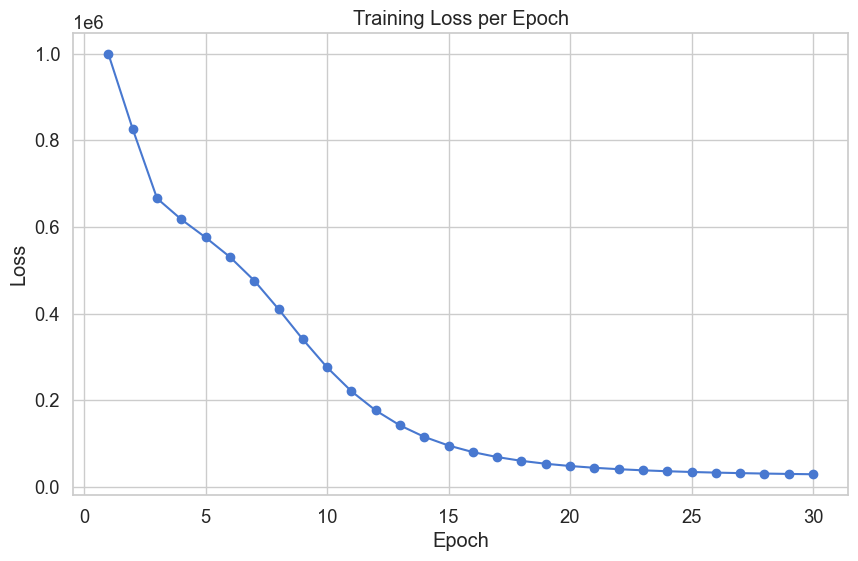

In [9]:
model = CF(num_users, num_items, num_factors=300, lr=0.01, reg=0.001, epochs=30)
model.train(ratings, item_id_to_index, user_id_to_index) 

# **Step 4: Ranking and Predicting Recommendations**  

In [10]:
def recommend_top_n_movies(user_id, model, item_id_to_index, user_id_to_index, ratings_df, movies, top_n=10):
    """
    Recommend top-n movies for user_id, print the results in a nice table format.

    Args:
        user_id (int): ID of the user to recommend.
        model: Trained model with a recommend function.
        item_id_to_index (dict): Mapping from item_id to index.
        user_id_to_index (dict): Mapping from user_id to index.
        ratings_df (DataFrame): Ratings data (user_id, item_id, rating).
        movies (DataFrame): Movie information (item_id, title, genres).
        top_n (int): Number of movies to recommend (default 10).

    Returns:
        DataFrame: Recommendation results.
    """

    recommendations = model.recommend(user_id, item_id_to_index, user_id_to_index, ratings_df, movies, top_n=top_n)
    result = []
    for item_id, score, weight in recommendations:
        movie_info = movies[movies['item_id'] == item_id].iloc[0]  # Lấy thông tin phim
        movie_title = movie_info['title']
        movie_genre = movie_info['genres']
        result.append({
            'Movie ID': item_id,
            'Movie': movie_title,
            'Genres': movie_genre,
            'Predicted Score': round(score, 2),
            'Weighted Score': round(weight, 2)
        })

    df_result = pd.DataFrame(result)
    print(f"\nTop {len(recommendations)} recommendations for User {user_id}:")
    print("{:<10} {:<50} {:<60} {:<20} {:<30}".format('Movie ID', 'Movie', 'Genres', 'Predicted Score', 'Weighted Score'))
    print("-" * 160)
    for _, row in df_result.iterrows():
        print("{:<10} {:<50} {:<60} {:<20.2f} {:<30.2f}".format(
            row['Movie ID'], row['Movie'], row['Genres'], row['Predicted Score'], row['Weighted Score']
        ))

    return df_result

df_recommend = recommend_top_n_movies(
    user_id=1,
    model=model,
    item_id_to_index=item_id_to_index,
    user_id_to_index=user_id_to_index,
    ratings_df=ratings,
    movies=movies,
    top_n=10 
)

scores:  [(np.int64(48), 5), (np.int64(527), np.float64(5.0)), (np.int64(1035), 5), (np.int64(1263), 5), (np.int64(3447), 5), (np.int64(595), np.float64(4.99)), (np.int64(1029), np.float64(4.99)), (np.int64(2355), np.float64(4.99)), (np.int64(1), np.float64(4.98)), (np.int64(1287), np.float64(4.98))]

Top 10 recommendations for User 1:
Movie ID   Movie                                              Genres                                                       Predicted Score      Weighted Score                
----------------------------------------------------------------------------------------------------------------------------------------------------------------
48         Pocahontas (1995)                                  Animation|Children's|Musical|Romance                         5.00                 0.82                          
527        Schindler's List (1993)                            Drama|War                                                    5.00                 0.43   

In [11]:
def predict_ratings_for_movie_of_user(user_id, movie_id, model, item_id_to_index, user_id_to_index):
    """
    Predict the rating for a specific movie and user, print the results in a nice table format.

    Args:
        user_id (int): ID of the user.
        movie_id (int): ID of the movie.
        model: Trained model with a predict function.
        item_content_matrix: Item content matrix.
        item_id_to_index (dict): Mapping from item_id to index.
        user_id_to_index (dict): Mapping from user_id to index.

    Returns:
        DataFrame: Prediction result.
    """

    movie_title = movies[movies['item_id'] == movie_id]['title'].values[0]
    movie_genre = movies[movies['item_id'] == movie_id]['genres'].values[0]

    score_predict = model.predict(user_id, movie_id, item_id_to_index, user_id_to_index)
    result = [{'Movie ID': movie_id ,'Movie': movie_title, 'Genres': movie_genre, 'Predicted Score': round(score_predict, 2)}]

    df_result = pd.DataFrame(result)

    print(f"\nPredicted Score for Movie {movie_id} of User {user_id}:")
    print("{:<10} {:<50} {:<60} {:<20}".format('Movie ID', 'Movie', 'Genres', 'Predicted Score'))
    print("-" * 140)
    for _, row in df_result.iterrows():
        print("{:<10} {:<50} {:<60} {:<20.2f}".format(
            row['Movie ID'], row['Movie'], row['Genres'], row['Predicted Score']
        ))

    return df_result

df_predict = predict_ratings_for_movie_of_user(
    user_id=1,
    movie_id=2081,
    model=model,
    item_id_to_index=item_id_to_index,
    user_id_to_index=user_id_to_index
)


Predicted Score for Movie 2081 of User 1:
Movie ID   Movie                                              Genres                                                       Predicted Score     
--------------------------------------------------------------------------------------------------------------------------------------------
2081       Little Mermaid, The (1989)                         Animation|Children's|Comedy|Musical|Romance                  4.91                


In [12]:
model.save_model('CF_SGD.pkl')

Model saved to CF_SGD.pkl


# **Step 5: Testing and Evaluating the Model**  

# Conclusion

- Cost before normalization: ~ 50 000 (0.05/step)
- Cost after normalization: ~ 30 000 (0.03/step)